# Called Strike Probability

Build a model to predict the probability of a called strike of a given pitch with various features.

## Exploratory Data Analysis

In [1]:
# import the needed packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time as time
from numpy import isnan
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, accuracy_score, log_loss, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

In [2]:
# load the dataset
pitch_data = pd.read_csv(r'C:\Users\allen\Desktop\Baseball Analytics Coding Task\CIN\pitch_data_one_month.csv')

In [3]:
# Summary of the dataframe with the pandas info() method.
pitch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125990 entries, 0 to 125989
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 125990 non-null  int64  
 1   GAME_ID                    125990 non-null  int64  
 2   PA_IN_GAME                 125990 non-null  int64  
 3   PITCH_IN_PA                125990 non-null  int64  
 4   CATCHER_ID                 125990 non-null  int64  
 5   PITCHER_ID                 125990 non-null  int64  
 6   BATTER_ID                  125990 non-null  int64  
 7   UMPIRE_ID                  125990 non-null  int64  
 8   BALLPARK_ID                125990 non-null  int64  
 9   BALLS                      125990 non-null  int64  
 10  STRIKES                    125990 non-null  int64  
 11  OUTS                       125990 non-null  int64  
 12  INNING                     125990 non-null  int64  
 13  INNING_HALF                12

In [4]:
# Top 5 rows of the pandas dataframe with the pandas head() method
pitch_data.head()

,Unnamed: 0,GAME_ID,PA_IN_GAME,PITCH_IN_PA,CATCHER_ID,PITCHER_ID,BATTER_ID,UMPIRE_ID,BALLPARK_ID,BALLS,...,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,EXIT_VELOCITY,LAUNCH_ANGLE,SPRAY_ANGLE
0,1,171,72,5,57,13,2,11,1,3,...,10.583700,15.77840,-6.68832,2.09536,0.350211,5.95656,6.33452,86.659058,-4.598840,-12.986703
1,2,171,25,1,33,480,121,11,1,0,...,20.652599,-7.98328,-4.67584,1.20689,-1.451240,5.81709,6.06574,NaN,NaN,NaN
2,3,171,63,2,57,247,201,11,1,1,...,-1.737540,8.00289,-10.34140,4.36072,-2.303100,6.16600,6.14947,NaN,NaN,NaN
3,4,171,10,4,57,245,312,11,1,3,...,14.339600,-6.51659,-5.61544,1.49181,-2.357300,5.16776,6.66450,NaN,NaN,NaN
4,5,171,11,3,57,245,2,11,1,1,...,5.516960,-12.98960,-5.74303,1.26949,-2.258840,5.28204,6.81603,106.085579,-10.664643,10.862201


In [5]:
# Descriptive statistics of the dataframe with the pandas describe() method
pitch_data.describe()

,Unnamed: 0,GAME_ID,PA_IN_GAME,PITCH_IN_PA,CATCHER_ID,PITCHER_ID,BATTER_ID,UMPIRE_ID,BALLPARK_ID,BALLS,...,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,EXIT_VELOCITY,LAUNCH_ANGLE,SPRAY_ANGLE
count,125990.000000,125990.000000,125990.000000,125990.000000,125990.000000,125990.000000,125990.000000,125990.000000,125990.000000,125990.000000,...,125477.000000,125477.000000,125478.000000,125478.000000,125477.000000,125477.000000,125477.000000,19709.000000,19709.000000,19709.000000
mean,62995.500000,209.136241,39.392841,2.934423,38.267918,266.021073,307.016152,45.107247,15.979998,0.893523,...,8.669586,-1.576582,-6.590230,0.615533,-0.695532,5.920421,6.087316,89.019422,11.638776,-1.271202
std,36370.324545,120.208387,23.266174,1.748255,21.973266,161.127249,181.163271,24.775812,8.973616,0.971364,...,8.713585,10.185401,1.908755,2.242874,1.975536,0.510017,0.494853,13.505985,24.970896,21.816151
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,-23.775900,-32.037102,-16.243299,-8.212550,-4.218120,0.911651,3.255160,15.828799,-82.159584,-171.274857
25%,31498.250000,105.000000,19.000000,1.000000,19.000000,127.000000,151.000000,25.000000,9.000000,0.000000,...,3.677170,-10.280800,-7.809838,-0.833356,-2.147160,5.657500,5.764640,80.467125,-4.176677,-17.612553
50%,62995.500000,210.000000,39.000000,3.000000,37.000000,254.000000,299.000000,47.000000,16.000000,1.000000,...,10.262000,-2.700850,-6.360590,0.761282,-1.483980,5.948610,6.094840,91.605530,12.548314,-1.749521
75%,94492.750000,314.000000,58.000000,4.000000,57.000000,405.000000,471.000000,66.000000,23.000000,2.000000,...,15.694800,6.523660,-5.192128,2.203208,1.430360,6.257400,6.423440,99.315315,28.257418,15.010160
max,125990.000000,416.000000,134.000000,14.000000,77.000000,556.000000,638.000000,87.000000,31.000000,4.000000,...,32.058800,27.212601,-0.886191,9.163620,5.021980,7.216850,8.866660,118.739052,89.137764,177.045273


# [An explanation of my chosen model features]

## Feature Selection

There are 40 features in this dataset. More complex classification models like the tree based models I will use later should be able to learn non-linear dependencies, I don't want to use basic linear metrics to remove some variables. However to simplify the model and for runtime considerations, I want to include features that are more strongly correlated with a pitch being called strike or not with my baseball knowledge. I select 15 of those.

My guess is that the pitch location(side and height) and strike zone(top and bottom) would be the most important features. As for Balls/Strikes, those are the ones that can influence the umpire's preference for their strike zone. Also, the pitcher side, pitch speed, pitch spin, pitch break(vertical and horizontal), release location(side, height, extension) could all potentially have different visual effect on the umpire and affect the result of the pitches. 

I wanted to include catcher/pitcher/batter/umpire id/pitch type at first, but eventually decided to abandon those for runtime considerations. I also exclude the variables controlled by the batters or the impact made at plate, like exit velocity, launch angle, spray angle, approach angle and the ones that are more of a runners/at bat situation like pitch in pa, pa in game, ballpark, team score, outs, etc.

In [6]:
# the 15 selected features
include=['BALLS', 'STRIKES', 'BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_SPEED',
         'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT', 'STRIKE_ZONE_TOP', 'STRIKE_ZONE_BOTTOM', 'SPIN_RATE',
         'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION']

# the ones that are categorical from those 15 features
categorical=['BALLS', 'STRIKES', 'BATTER_SIDE', 'PITCHER_SIDE']

# the ones that are numeric from those 15 features
numeric=['PITCH_SPEED', 'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT', 'STRIKE_ZONE_TOP', 'STRIKE_ZONE_BOTTOM', 'SPIN_RATE',
         'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION']

# [A model to predict the probability of a called strike of a given pitch ]

## Model Building

In [7]:
# check what I have in the PITCH_RESULT column
pitch_data['PITCH_RESULT'].unique()

array(['InPlay', 'StrikeSwinging', 'BallCalled', 'FoulBall',
       'StrikeCalled', 'HitByPitch', nan, 'Undefined'], dtype=object)

To build a model predicting the probability of a called strike of a given pitch, I will only include the rows that have BallCalled or StrikeCalled as their pitch result.

In [8]:
pitch_data_model = pitch_data[(pitch_data['PITCH_RESULT']=='BallCalled')|(pitch_data['PITCH_RESULT']=='StrikeCalled')]

In [9]:
# build a new dataframe pitch_data_include to include the 15 features
pitch_data_include = pitch_data_model[include]

# turn the categorical variables into 'category' type
pitch_data_include[categorical] = pitch_data_include[categorical].astype('category')

# one-hot encode these categorical variables
pitch_data_include = pd.concat([pitch_data_include, pd.get_dummies(pitch_data_include[categorical])], axis=1) 

# drop the unnecessary columns
pitch_data_include = pitch_data_include.drop(columns=categorical)

# scale and center numeric variables
pitch_data_include[numeric] = StandardScaler().fit_transform(pitch_data_include[numeric]) 

C:\Users\allen\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Check Missing Values

In [10]:
# check which columns have missing values
pitch_data_include.columns[pitch_data_include.isna().any()].tolist()

['PITCH_SPEED',
 'PITCH_LOCATION_SIDE',
 'PITCH_LOCATION_HEIGHT',
 'SPIN_RATE',
 'INDUCED_VERTICAL_BREAK',
 'HORIZONTAL_BREAK',
 'RELEASE_SIDE',
 'RELEASE_HEIGHT',
 'RELEASE_EXTENSION']

### Missing Data Imputation

A popular approach to missing data imputation is to use a model to predict the missing values. This requires a model to be created for each input variable that has missing values. Although any one among a range of different models can be used to predict the missing values, the k-nearest neighbor (KNN) algorithm has proven to be generally effective, often referred to as “nearest neighbor imputation.”

In [11]:
# turn the PITCH_RESULT column into categorical type as well
pitch_data_model.loc[:, 'PITCH_RESULT'] = pitch_data_model.loc[:, 'PITCH_RESULT'].astype('category')

# set input and output elements
X = pitch_data_include
y = pitch_data_model.loc[:, 'PITCH_RESULT']

# define imputer
imputer = KNNImputer()

# fit on the dataset
imputer.fit(X)

# transform the dataset
Xtrans = imputer.transform(X)

# print total missing
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

# put the transformed dataset back into pitch_data_include
pitch_data_include[pitch_data_include.columns]=Xtrans

C:\Users\allen\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Missing: 0


In [12]:
# set input and output elements again
X = pitch_data_include
y = pitch_data_model['PITCH_RESULT']

I've settled on 6 popular classifiers to compare. I'll use:<br>

logistic regression<br>
k-nearest neighbors<br>
decision tree<br>
random forest<br>
gradient boosting<br>
xgboost<br>

And I'm going to use 4 metrics to evaluate the models, which together should give a good picture of the best overall model:<br>

F1 score<br>
ROC AUC<br>
balanced accuracy<br>
log loss<br>
I'll run with largely default settings for each of the models to keep a relatively level playing field. Once I pick the best model, I'll do some parameter tuning.

In [13]:
# scoring metrics
scoring = {
    'f1_weighted': 'f1_weighted',
    'accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc_ovr_weighted',
    'neg_log_loss': 'neg_log_loss'
    }

# for results df
eval_cols = [
    'models',
    'F1 Score',
    'Balanced Accuracy',
    'ROC AUC',
    'Neg Log Loss'
    ]

# define classifier models
classifiers = [
    LogisticRegression(multi_class='multinomial', max_iter=100),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

# classifier names
clf_names = [
    'Logistic Regression',
    'KNN',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'XGBClassifier'
    ]

I drop each model into sklearn's cross_validate and compare the scores.

In [14]:
f1, acc, roc_auc, log_loss = [], [], [], []
for clf, clf_nm in zip(classifiers, clf_names):

    start = time.time()
    
    # cross-validate 5 times
    res = cross_validate(clf, X, y, cv=5, scoring=scoring)
    results = pd.DataFrame(res)
    
    stop = time.time()

    print('Time to cross-validate %s = %0.3f min.' % (clf_nm, (stop - start) / 60))

    # save average scores
    f1.append(np.mean(results.test_f1_weighted))
    acc.append(np.mean(results.test_accuracy))
    roc_auc.append(np.mean(results.test_roc_auc))
    log_loss.append(np.mean(results.test_neg_log_loss))

# save results to df
model_eval = pd.DataFrame(data=zip(clf_names, f1, acc, roc_auc, log_loss),
                          columns=eval_cols)

display(model_eval)

Time to cross-validate Logistic Regression = 0.351 min.
Time to cross-validate KNN = 5.005 min.
Time to cross-validate Decision Tree = 0.235 min.
Time to cross-validate Random Forest = 2.423 min.
Time to cross-validate Gradient Boosting = 3.982 min.
Time to cross-validate XGBClassifier = 1.152 min.


,models,F1 Score,Balanced Accuracy,ROC AUC,Neg Log Loss
0,Logistic Regression,0.597159,0.514412,0.705458,-0.562351
1,KNN,0.821406,0.796069,0.879452,-0.852712
2,Decision Tree,0.894225,0.876705,0.877228,-3.640682
3,Random Forest,0.924076,0.911507,0.973251,-0.211355
4,Gradient Boosting,0.927982,0.916905,0.979222,-0.174972
5,XGBClassifier,0.927017,0.916824,0.978974,-0.175782


Overall, the gradient boosting model is the best with better F1 score, Accuracy, ROC AUC and Log Loss. XGBClassifier has basically the same result, but I'll go with gradient boosting model this time.

## Parameter Tuning

### Run a baseline model without tuning<br>
I use the following baseline scikit-learn library settings.<br>

Tree specific parameters<br>
n_estimators=100 (number of trees)<br>
max_depth=3<br>
min_samples_split=2<br>
min_samples_leaf=1<br>
subsample=1.0<br>

Other Parameters<br>
learning_rate=0.1 (shrinkage)<br>
subsample: 1<br>

Accuracy of the GBM on test set: 0.920
              precision    recall  f1-score   support

  BallCalled       0.94      0.95      0.94      9050
StrikeCalled       0.88      0.86      0.87      4135

    accuracy                           0.92     13185
   macro avg       0.91      0.90      0.91     13185
weighted avg       0.92      0.92      0.92     13185



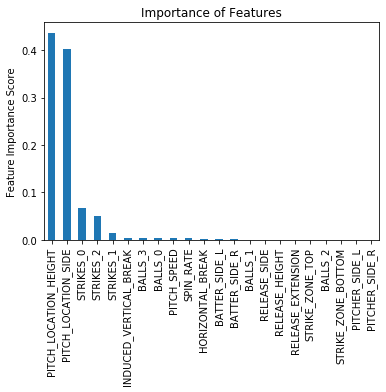

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

PITCH_LOCATION_SIDE, PITCH_LOCATION_HEIGHT, STRIKES_2, STRIKES_0, STRIKES_1 contributed most to my model, which makes a lot of sense. It's easy to guess why pitch location is highly related to the pitch being called strike or not. As for strikes count, it's probably due to the referee preference for modifying the strike zone in different situations.

### Tunign n_estimators and Learning rate

n_estimators captures the number of trees that we add to the model. A high number of trees can be computationally expensive. Generally, with a change in learning rate,n_estimators should also be adjusted (10-fold decrease in learning_rate should go in line with a approx. 10-fold increase in n_estimators.

In [16]:
p_test2 = {'learning_rate':[0.1,0.01,0.001], 'n_estimators':[100,1000,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\allen\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 16.33315277, 156.06967835, 252.3028266 ,  15.59858069,
         141.38011837, 221.87173266,  14.40680652, 125.736305  ,
         205.92876129]),
  'std_fit_time': array([ 0.72919377,  4.49137056,  2.68382233,  0.9876293 ,  2.17534084,
          2.10724028,  1.36837745,  1.3913435 , 23.8087727 ]),
  'mean_score_time': array([0.13831296, 0.55126104, 1.32599621, 0.15343156, 0.53493419,
         0.969912  , 0.11902804, 0.64105458, 0.86535115]),
  'std_score_time': array([0.07583394, 0.28516719, 0.19665249, 0.0522208 , 0.14890979,
         0.30234733, 0.03523854, 0.22231631, 0.29179728]),
  'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[100, 1000, 1750, 100, 1000, 1750, 100, 1000, 1750],
               mask=[False, 

### max_depth

max_depth bounds the maximum depth of the tree. We can use the obtained results to tune the max_depth parameter. 

In [17]:
p_test3 = {'max_depth':[3,5,7]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1,n_estimators=1000, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\allen\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([124.96685929, 200.71301074, 259.4485775 ]),
  'std_fit_time': array([ 1.05045457,  1.10675626, 33.32031444]),
  'mean_score_time': array([0.60935297, 0.95943122, 0.93562775]),
  'std_score_time': array([0.26219487, 0.16218631, 0.28137736]),
  'param_max_depth': masked_array(data=[3, 5, 7],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 3}, {'max_depth': 5}, {'max_depth': 7}],
  'split0_test_score': array([0.92690557, 0.92453546, 0.92273417]),
  'split1_test_score': array([0.92576792, 0.92444065, 0.92434585]),
  'split2_test_score': array([0.92908608, 0.92956011, 0.92918089]),
  'split3_test_score': array([0.92908608, 0.92804323, 0.92861206]),
  'split4_test_score': array([0.92861206, 0.9273796 , 0.92908608]),
  'mean_test_score': array([0.92789154, 0.92679181, 0.92679181]),
  'std_test_score': array([0.00133078, 0.00200968, 0.00271042]),
  'rank_test_score': array([1, 3, 2])},
 {'max_

### Min sample split and min samples leaf

min_samples_split sets the minimum number of samples to split while min_samples_leaf sets the minimum number of samples to form a leaf.

In [18]:
p_test4 = {'min_samples_split':[2,50,100], 'min_samples_leaf':[1,5,9]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=3, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\allen\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([123.81140437, 122.91462288, 123.358076  , 123.23501768,
         127.32602205, 123.54353271, 122.9699892 , 121.33298655,
         111.94919043]),
  'std_fit_time': array([ 0.89335698,  1.06764985,  1.33287742,  0.44159971,  2.37991658,
          0.78231289,  0.43347736,  0.77376285, 20.55338198]),
  'mean_score_time': array([0.70622993, 0.73065367, 0.40623603, 0.64263649, 0.40019612,
         0.56287518, 0.65310607, 0.54373426, 0.43341656]),
  'std_score_time': array([0.24031191, 0.26569058, 0.07193816, 0.34848462, 0.04761548,
         0.23424781, 0.26504641, 0.18258882, 0.20631173]),
  'param_min_samples_leaf': masked_array(data=[1, 1, 1, 5, 5, 5, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_samples_split': masked_array(data=[2, 50, 100, 2, 50, 100, 2, 50, 100],
               mask=[False, False, False, False, False, False,

### Max features

The square root of features is usually a good starting point. Let's use CV to tune the parameter.

In [20]:
p_test5 = {'max_features':[2,5,10]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=3, min_samples_split=50, min_samples_leaf=5, subsample=1, random_state=10), 
param_grid = p_test5, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\allen\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 78.45912037, 145.59197631, 233.49271832]),
  'std_fit_time': array([ 2.11662907,  1.0054368 , 30.45410523]),
  'mean_score_time': array([0.56749029, 0.57185602, 0.59504457]),
  'std_score_time': array([0.23851729, 0.25912376, 0.32167753]),
  'param_max_features': masked_array(data=[2, 5, 10],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 2}, {'max_features': 5}, {'max_features': 10}],
  'split0_test_score': array([0.9274744 , 0.92709518, 0.92681077]),
  'split1_test_score': array([0.9254835 , 0.92567311, 0.92652636]),
  'split2_test_score': array([0.93041335, 0.92918089, 0.93031854]),
  'split3_test_score': array([0.92880167, 0.93022374, 0.92984452]),
  'split4_test_score': array([0.92870686, 0.92823284, 0.92813804]),
  'mean_test_score': array([0.92817596, 0.92808115, 0.92832765]),
  'std_test_score': array([0.00163834, 0.00158707, 0.00153923]),
  'rank_test_score': array([2, 3,

### Subsample

Subsample sets the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.

In [22]:
p_test6= {'subsample':[0.7,0.85,1]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=3, min_samples_split=50, min_samples_leaf=5,max_features=10 , random_state=10), 
param_grid = p_test6, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\allen\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([217.57502508, 236.20861716, 231.75644674]),
  'std_fit_time': array([ 6.16541282,  1.00774309, 21.76429024]),
  'mean_score_time': array([0.52994833, 0.74260073, 0.573804  ]),
  'std_score_time': array([0.28300397, 0.22647323, 0.27447263]),
  'param_subsample': masked_array(data=[0.7, 0.85, 1],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.7}, {'subsample': 0.85}, {'subsample': 1}],
  'split0_test_score': array([0.92728479, 0.92756921, 0.92681077]),
  'split1_test_score': array([0.92605233, 0.92690557, 0.92652636]),
  'split2_test_score': array([0.92785362, 0.92785362, 0.93031854]),
  'split3_test_score': array([0.93012893, 0.92851725, 0.92984452]),
  'split4_test_score': array([0.92775882, 0.92851725, 0.92813804]),
  'mean_test_score': array([0.9278157 , 0.92787258, 0.92832765]),
  'std_test_score': array([0.00132265, 0.00060971, 0.00153923]),
  'rank_test_score': array([3, 2, 1])

### Evaluation of final model on Test set

Accuracy of the GBM on test set: 0.928
              precision    recall  f1-score   support

  BallCalled       0.95      0.95      0.95      9050
StrikeCalled       0.88      0.89      0.88      4135

    accuracy                           0.93     13185
   macro avg       0.92      0.92      0.92     13185
weighted avg       0.93      0.93      0.93     13185



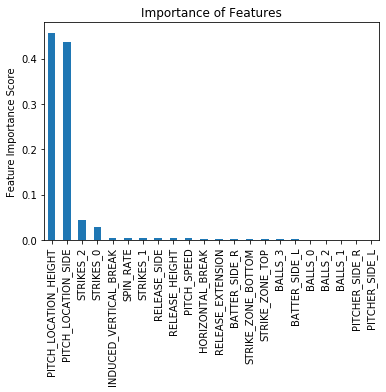

In [23]:
new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=3, min_samples_split=50, min_samples_leaf=5,max_features=10 , subsample=1, random_state=10)
new.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(new.score(X_test, y_test)))
pred=new.predict(X_test)
print(classification_report(y_test, pred))

# [A visualization of my model outputs]

## Comparison of ROC AUC

Comparing the area under the curve, the two models(baseline and the parameter tuned model) only slightly differ. Model New(the parameter tuned one) performs best on the AUC measure for the test dataset.

C:\Users\allen\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


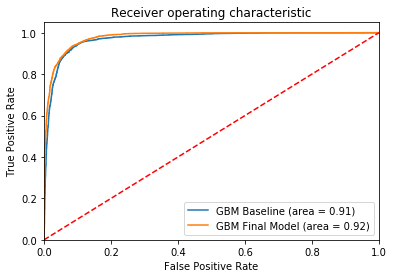

In [24]:
# set input and output elements again
X = pitch_data_include
pitch_data_model.loc[:,'PITCH_RESULT'] = pitch_data_model.loc[:,'PITCH_RESULT'].replace({'StrikeCalled': 1, 'BallCalled': 0})
y = pitch_data_model.loc[:, 'PITCH_RESULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#run models
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)

new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=3, min_samples_split=50, min_samples_leaf=5, max_features=10 , subsample=0.7, random_state=10)
new.fit(X_train,y_train)

#calculate values for ROC AUC plot
#baseline model
baseline_roc_auc = roc_auc_score(y_test, baseline.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])
#new tuned model 
new_roc_auc = roc_auc_score(y_test, new.predict(X_test))
fprnew, tprnew, thresholds_new = roc_curve(y_test, new.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GBM Baseline (area = %0.2f)' % baseline_roc_auc)
plt.plot(fprnew, tprnew, label='GBM Final Model (area = %0.2f)' % new_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# [A calculation of which pitcher in the sample lost the most strikes relative to expectation]

In [31]:
# set input and output elements again
X = pitch_data_include
pitch_data_model.loc[:,'PITCH_RESULT'] = pitch_data_model.loc[:,'PITCH_RESULT'].replace({1: 'StrikeCalled', 0: 'BallCalled'})
y = pitch_data_model.loc[:, 'PITCH_RESULT']

# apply the model
model=GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=3, min_samples_split=50, min_samples_leaf=5, subsample=1, max_features=10, random_state=10)
model.fit(X, y)
strike_pred = model.predict(X)
strike_proba = model.predict_proba(X)

# put it all together in the same dataframe
data_result = {'Game ID': pitch_data_model.loc[:, 'GAME_ID'],
               'PA in Game': pitch_data_model.loc[:, 'PA_IN_GAME'],
               'Pitch in PA': pitch_data_model.loc[:, 'PITCH_IN_PA'],
               'Pitcher ID': pitch_data_model.loc[:, 'PITCHER_ID'],
               'Strike Probability': strike_proba[:,1]*100,
               'Pitch Result Prediction': strike_pred,
               'Actual Pitch Result': pitch_data_model.loc[:, 'PITCH_RESULT']
               }
prediction_table = pd.DataFrame(data_result)
print(prediction_table.head())

C:\Users\allen\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


    Game ID  PA in Game  Pitch in PA  Pitcher ID  Strike Probability  \
2       171          63            2         247            0.009852   
3       171          10            4         245           91.951201   
7       171          58            1          60            0.645818   
9       171          36            2         480           34.835882   
10      171          59            3          60           81.474641   

   Pitch Result Prediction Actual Pitch Result  
2               BallCalled          BallCalled  
3             StrikeCalled          BallCalled  
7               BallCalled          BallCalled  
9               BallCalled        StrikeCalled  
10            StrikeCalled        StrikeCalled  


In [32]:
# calculation of which pitcher in the sample lost the most strikes relative to expectation
prediction_table['Pitch Result Prediction'] = prediction_table['Pitch Result Prediction'].replace({'StrikeCalled': 1, 'BallCalled': 0})
prediction_table['Actual Pitch Result'] = prediction_table['Actual Pitch Result'].replace({'StrikeCalled': 0, 'BallCalled': 1})
prediction_table = prediction_table[prediction_table['Pitch Result Prediction']==1]
lost_strikes = (prediction_table.groupby('Pitcher ID')['Actual Pitch Result'].sum()/prediction_table.groupby('Pitcher ID')['Pitch Result Prediction'].sum()).reset_index()
# simply put, the lost strikes percentage = Predicted strikes being called ball/Predicted Strikes
lost_strikes = lost_strikes.rename(columns={0: "Lost Strikes Percentage"})
lost_strikes['Lost Strikes Percentage']=100*lost_strikes['Lost Strikes Percentage']
lost_strikes = lost_strikes.sort_values(by='Lost Strikes Percentage', ascending=False)
lost_strikes

,Pitcher ID,Lost Strikes Percentage
128,129,100.0
181,182,50.0
424,426,50.0
473,475,50.0
209,210,50.0
...,...,...
183,184,0.0
310,312,0.0
155,156,0.0
313,315,0.0
